In [1]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [2]:
### IGNORE THIS CELL, IT WILL BE OVERWRITTEN
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 2005
end_year = 2015
exclude_countries = []
pickle_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2'
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": True,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "iterative",
    "opt.meth": "BFGS",
    "inst.stata": False,
}
plm_formula = 'ENI ~ lag(ENI, 1:2) + POP + AFL + AFL2 + URB + CTS + TI + KAOPEN | lag(ENI, 2:99)'
plm_params = {
    'effect': 'twoways',
    'model': 'twostep',
    'collapse': False,
    'transformation': 'd',
}

In [3]:
# Parameters
dataset_file = "/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv"
index_fields = ["Country", "Year"]
data_fields = ["ENI", "POP", "URB", "AFL", "TI", "TS", "CTS", "KAOPEN"]
prefix = "template"
start_year = 1996
end_year = 2005
exclude_countries = []
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": False,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "twostep",
    "opt.meth": "none",
    "inst.stata": False,
}
pickle_file = "/home/drake/workspace/em-2020/analysis/D3_gmm/diffGMM_full_model_all_1996_2005.pickle.bz2"


**End of parameter section** 

In [4]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get pdynmc_params plm_formula plm_params

# SoS mangles dict keys, for no apparent reason
names(pdynmc_params) <- gsub('_', '.', names(pdynmc_params))
names(plm_params) <- gsub('_', '.', names(plm_params))

suppressMessages({
library(dplyr)
library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))

Country,min,max
<fct>,<int>,<int>
ALB,1996,2005
ARG,1996,2005
ARM,2005,2005
AUS,1996,2005
AUT,1996,2005
AZE,2001,2005


In [5]:
pdynmc_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] FALSE

$use.mc.nonlin
[1] FALSE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"    "AFL"    "AFL2"   "URB"    "CTS"    "TI"     "KAOPEN"

$lagTerms.reg.fur
[1] 0 0 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "twostep"

$opt.meth
[1] "none"

$inst.stata
[1] FALSE

In [6]:
pdynmc_base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(pdynmc_base_params, pdynmc_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary


Dynamic linear panel estimation (twostep)
Estimation steps: 2

Coefficients:
            Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)   
L1.ENI     0.4182705   0.1565309       2.672      0.00754 **
L2.ENI    -0.0201592   0.0682321      -0.295      0.76799   
L0.POP    -0.4237589   0.2725194      -1.555      0.11995   
L0.AFL    -0.1760835   0.3913001      -0.450      0.65271   
L0.AFL2   -0.0252958   0.0203830      -1.241      0.21461   
L0.URB     0.6533654   0.2859125       2.285      0.02231 * 
L0.CTS     0.0415583   0.0204079       2.036      0.04175 * 
L0.TI     -0.0006841   0.0064586      -0.106      0.91558   
L0.KAOPEN -0.0050574   0.0051734      -0.978      0.32807   
1999       0.0007114   0.0097215       0.073      0.94181   
2000      -0.0047866   0.0165626      -0.289      0.77258   
2001       0.0134986   0.0269719       0.500      0.61708   
2002       0.0146167   0.0342579       0.427      0.66938   
2003       0.0380655   0.0429192       0.887      0.37508   
2004   


Call:
lm(formula = residuals ~ fitted, data = pdynmc_resid)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41510 -0.02239 -0.00077  0.02266  0.21262 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.017714   0.003531  -5.017 7.14e-07 ***
fitted      -0.401176   0.062083  -6.462 2.32e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05181 on 538 degrees of freedom
  (90 observations deleted due to missingness)
Multiple R-squared:  0.07203,	Adjusted R-squared:  0.0703 
F-statistic: 41.76 on 1 and 538 DF,  p-value: 2.317e-10


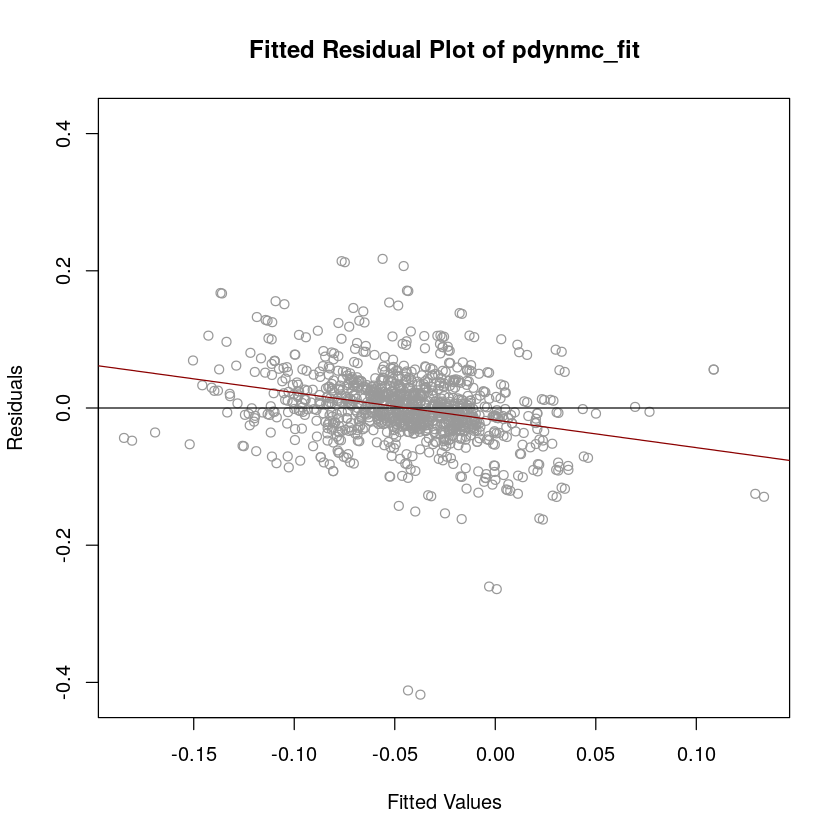

In [7]:
pdynmc_resid <- data.frame(residuals=unlist(residuals(pdynmc_fit)),
                           fitted=unlist(fitted.values(pdynmc_fit)))
resid.reg <- lm(residuals ~ fitted, data=pdynmc_resid)
plot(pdynmc_fit)
abline(resid.reg, col='darkred')
summary(resid.reg)

In [8]:
jtest.fct(pdynmc_fit)
ser.corr1 <- mtest.fct(pdynmc_fit, t.order = 1)
ser.corr1
ser.corr2 <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr2


	J-Test of Hansen

data:  2step GMM Estimation; H0: overidentifying restrictions valid
chisq = 43.279, df = 33, p-value = 0.1086



	Arrelano and Bond (1991) serial correlation test of degree 1

data:  2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
normal = -3.2328, p-value = 0.001226



	Arrelano and Bond (1991) serial correlation test of degree 2

data:  2step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = 1.0749, p-value = 0.2824


In [9]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr1, ser.corr2),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,43.278994,chisq,1.086371e-01,2step GMM Estimation; H0: overidentifying restrictions valid
Wald test,171.346084,chisq,3.235015e-32,2step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,19.080092,chisq,7.940111e-03,2step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 1,-3.232801,normal,1.225828e-03,2step GMM Estimation; H0: no serial correlation of order 1 in the error terms
Arrelano and Bond (1991) serial correlation test of degree 2,1.074944,normal,2.823996e-01,2step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [10]:
# plm.formula <- as.formula(plm_formula)
# plm.params = modifyList(list(plm.formula,
#                              data=data.panel),
#                         plm_params)
# z2 <- do.call(pgmm, plm.params)
# z2$call <- plm.formula
# summary(z2, robust = TRUE)

In [11]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)

In [12]:
%get pdynmc_coef pdynmc_tests pdynmc_resid --from R
import pickle
import bz2

with bz2.BZ2File(pickle_file, 'w') as fd:
    pickle.dump({
        'pdynmc_coef': pdynmc_coef,
        'pdynmc_tests': pdynmc_tests,
        'pdynmc_resid': pdynmc_resid,
        'pdynmc_params': pdynmc_params,
        'start_year': start_year,
        'end_year': start_year,
        'varname.reg.fur': start_year,
        'start_year': start_year,
    }, fd)